<a href="https://colab.research.google.com/github/legacypak02/TrashClassifier/blob/master/AI_Project_Modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sb

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [ ]:
!git clone https://github.com/legacypak02/TrashClassifier.git
%cd TrashClassifier/

Cloning into 'TrashClassifier'...
remote: Enumerating objects: 2570, done.
remote: Counting objects: 100% (2570/2570), done.
remote: Compressing objects: 100% (2569/2569), done.
remote: Total 2570 (delta 16), reused 2534 (delta 0), pack-reused 0
Receiving objects: 100% (2570/2570), 53.46 MiB | 19.46 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Checking out files: 100% (2531/2531), done.
/content/TrashClassifier


In [43]:
data_dir = Path('dataset-resized/')
filepaths = list(data_dir.glob(r'**/*.jpg'))
def proc_img(filepath):

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(6)

,Filepath,Label
0,dataset-resized/plastic/plastic110.jpg,plastic
1,dataset-resized/cardboard/cardboard367.jpg,cardboard
2,dataset-resized/cardboard/cardboard30.jpg,cardboard
3,dataset-resized/paper/paper486.jpg,paper
4,dataset-resized/cardboard/cardboard337.jpg,cardboard
5,dataset-resized/plastic/plastic7.jpg,plastic


In [46]:
print(f'Number of pics in Directory: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Lables: {df.Label.unique()}')

Number of pics in Directory: 2527

Number of different labels: 6

Lables: ['plastic' 'cardboard' 'paper' 'glass' 'metal' 'trash']


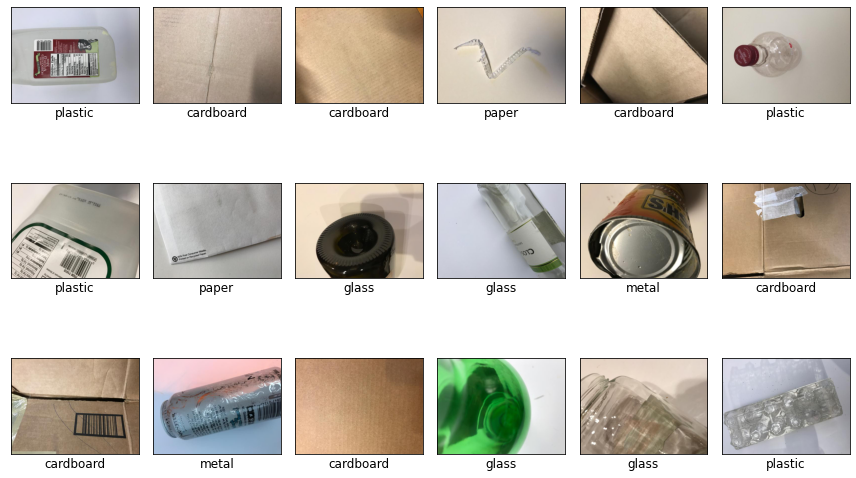

In [45]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(12, 8), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df.Filepath[i]))
  ax.set_xlabel(df.Label[i], fontsize = 12)
plt.tight_layout()
plt.show()

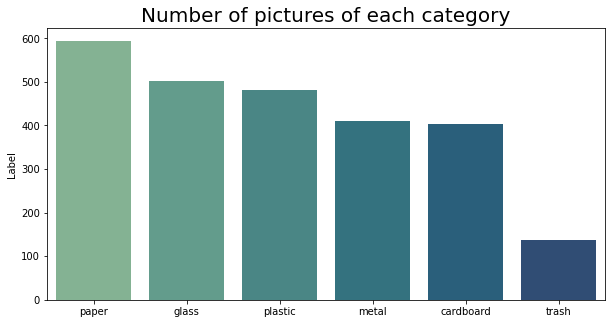

In [41]:
vc = df['Label'].value_counts()
plt.figure(figsize=(10,5))
sb.barplot(x = vc.index, y = vc, palette = "crest", ci="sd")
plt.title("Number of pictures of each category", fontsize = 20)
plt.show()
#Trash(일반쓰레기)는 데이터 수가 다른 label에 비해 적어서 학습이 제대로 이루어지지 않을 가능성이 높음.

In [ ]:
train_df,test_df = train_test_split(df, test_size=0.1,random_state=0) #테스트용 데이터는 전체 데이터 수의 10%로.
train_df.shape,test_df.shape

((2274, 2), (253, 2))

In [ ]:
import numpy as np
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)
#ImageDataGenerator를 통해 validation 비율은 전체 데이터 수의 20%로. Validation set은 추후 학습이 완료된 모델을 검증하기 위함.
#batch_size는 training set과 validation set을 쪼개서 효율적인 리소스 사용을 하기 위함.
train_gen = train_datagen.flow_from_directory('dataset-resized', target_size = (224, 224), batch_size = 32, seed=123, class_mode = 'categorical', subset='training')
val_gen = train_datagen.flow_from_directory('dataset-resized', target_size = (224, 224), batch_size = 32, seed=123, class_mode = 'categorical', subset='validation')

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [49]:
# Initialising the CNN(레이어를 선형으로 연결하여 구성)
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution (activation function으로 Relu를 사용하면 overfitting을 방지해줄 수 있음)
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[224, 224, 3]))

# Step 2 - Pooling(convolution filter를 거친 결과로 얻은 feature map에서 특정영역을 형성 후 해당 영역에서 가장 큰 값 도출)
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Adding convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Step 3 - Flattening (Data Type을 fully connected 네트워크 형태로 변경)
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection (Convolution과 Pooling 프로세스를 기반으로 labelling)
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer (6개의 class로 분류)
cnn.add(tf.keras.layers.Dense(units=6, activation='softmax'))

# Compiling the CNN(Optimizer로는 Adam을 사용하는데, 연산을 효율적으로 할 수 있기 때문.)
cnn.compile(optimizer = 'adam', 
            loss = 'categorical_crossentropy', 
            metrics = ['accuracy'])
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 93312)             0         
                                                                 
 dense_12 (Dense)            (None, 128)              

In [ ]:
cnn.fit(x = train_gen, validation_data = val_gen, epochs = 10)

Epoch 1/10
64/64 [==============================] - 155s 2s/step - loss: 1.8718 - accuracy: 0.3172 - val_loss: 1.5517 - val_accuracy: 0.3797
Epoch 2/10
64/64 [==============================] - 136s 2s/step - loss: 1.2513 - accuracy: 0.5336 - val_loss: 1.5516 - val_accuracy: 0.4135
Epoch 3/10
64/64 [==============================] - 136s 2s/step - loss: 0.9277 - accuracy: 0.6625 - val_loss: 1.4796 - val_accuracy: 0.4414
Epoch 4/10
64/64 [==============================] - 135s 2s/step - loss: 0.6415 - accuracy: 0.7935 - val_loss: 1.5842 - val_accuracy: 0.4453
Epoch 5/10
64/64 [==============================] - 137s 2s/step - loss: 0.4020 - accuracy: 0.8918 - val_loss: 1.8713 - val_accuracy: 0.4274
Epoch 6/10
64/64 [==============================] - 132s 2s/step - loss: 0.2191 - accuracy: 0.9387 - val_loss: 2.1828 - val_accuracy: 0.4334
Epoch 7/10
64/64 [==============================] - 134s 2s/step - loss: 0.1915 - accuracy: 0.9545 - val_loss: 2.7494 - val_accuracy: 0.4354
Epoch 8/10
64

In [50]:
def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치
        y_col='Label', # 클래스
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32, # 데이터 배치 크기
        shuffle=True, # 데이터 뒤섞을 지 여부
        seed=0,
        subset='training', # train 인지 val인지 설정
        rotation_range=50, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        vertical_flip=True, # 상하 반전 True
        brightness_range=(0.1, 0.9), # 이미지 밝기 조절
        fill_mode="nearest"
        # Augmentation을 진행할 시, 이미지가 비는 곳에 가까운 곳의 픽셀값으로 채움.
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=50,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        vertical_flip=True, 
        brightness_range=(0.1, 0.9),
        fill_mode="nearest"
    )
    # Test Set은 당연히 augmentation 과정이 필요없음.
    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [51]:
#MobileNetV2 모델로 학습
models = {
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0}
}
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# pre_trained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 training 중 손실을 최소화
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(6, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # 모델 학습
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 2047 validated image filenames belonging to 6 classes.
Found 227 validated image filenames belonging to 6 classes.
Found 253 validated image filenames belonging to 6 classes.


MobileNetV2          trained in 145.09 sec
219055592/219055592 [==============================] - 2s 0us/step
InceptionResNetV2    trained in 573.81 sec


In [52]:
for name, model in models.items():
    
    # 테스트데이터의 label 예측
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # label 맵핑
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# 나온 결과를 기반으로 DataFrame 생성
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

8/8 [==============================] - 10s 1s/step
**MobileNetV2 has a 81.03% accuracy on the test set**
8/8 [==============================] - 65s 8s/step
**InceptionResNetV2 has a 75.49% accuracy on the test set**


,model,val_accuracy,accuracy,Training time (sec)
0,MobileNetV2,0.8062,0.8103,145.09
1,InceptionResNetV2,0.7577,0.7549,573.81


In [55]:
train_df,test_df = train_test_split(df, test_size=0.1, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()
#MobileNetV2 성능확인(MobileNetV2가 시간이 적게 들고 동시에 accuracy가 80%정도 기록 / Epoch를 10회로 설정했을 때, 6회가 넘어갈 때부터 accuracy가 감소하기에 6회로 다시 설정) 
model = get_model(tf.keras.applications.MobileNetV2)
history = model.fit(train_images,validation_data=val_images,epochs=6)

Found 2047 validated image filenames belonging to 6 classes.
Found 227 validated image filenames belonging to 6 classes.
Found 253 validated image filenames belonging to 6 classes.
Epoch 1/6
64/64 [==============================] - 85s 1s/step - loss: 0.8004 - accuracy: 0.6996 - val_loss: 0.5980 - val_accuracy: 0.7841
Epoch 2/6
64/64 [==============================] - 83s 1s/step - loss: 0.3671 - accuracy: 0.8769 - val_loss: 0.5498 - val_accuracy: 0.8150
Epoch 3/6
64/64 [==============================] - 81s 1s/step - loss: 0.2150 - accuracy: 0.9311 - val_loss: 0.6049 - val_accuracy: 0.7974
Epoch 4/6
64/64 [==============================] - 83s 1s/step - loss: 0.1292 - accuracy: 0.9575 - val_loss: 0.5717 - val_accuracy: 0.8150
Epoch 5/6
64/64 [==============================] - 80s 1s/step - loss: 0.0791 - accuracy: 0.9795 - val_loss: 0.5937 - val_accuracy: 0.8150
Epoch 6/6
64/64 [==============================] - 82s 1s/step - loss: 0.0490 - accuracy: 0.9907 - val_loss: 0.5830 - val_ac

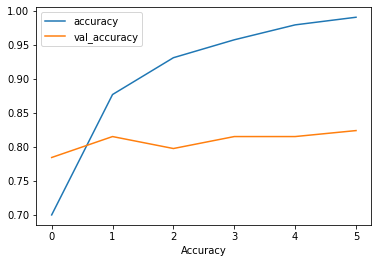

In [57]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

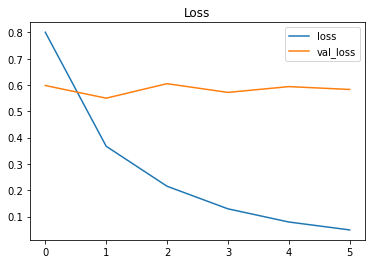

In [68]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
def printmd(string):    
    display(Markdown(string))

In [ ]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# 테스트 이미지에 대해 predict
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# label 맵핑
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# test set의 accuracy 확인(83.0%)
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
printmd(f'# Accuracy on the test set: {acc * 100:.2f}%')

8/8 [==============================] - 12s 1s/step


# Accuracy on the test set: 86.17%

In [ ]:
from sklearn.metrics import classification_report
print('\n\n', classification_report(y_test, pred))



               precision    recall  f1-score   support

   cardboard       0.97      0.82      0.89        34
       glass       0.95      0.80      0.87        65
       metal       0.88      0.87      0.88        53
       paper       0.87      1.00      0.93        48
     plastic       0.78      0.82      0.80        44
       trash       0.50      0.89      0.64         9

    accuracy                           0.86       253
   macro avg       0.83      0.87      0.83       253
weighted avg       0.88      0.86      0.86       253



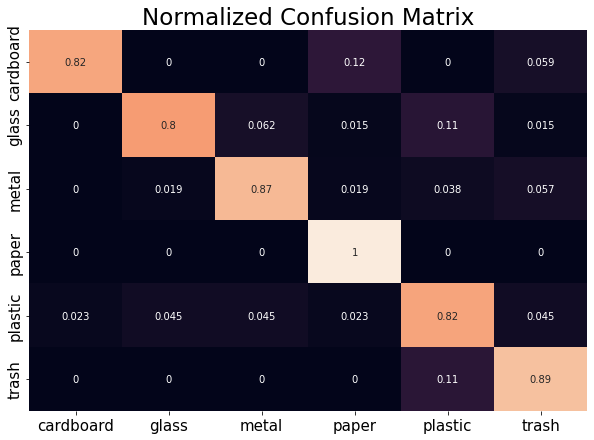

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Trash 부분의 confusion matrix를 확인해보면 알겠지만 0.56으로 다른 데이터에 비해 accuracy가 많이 낮은 것으로 나온다. 데이터 양이 다른 데이터에 비해 다소 적은 것이 영향을 크게 준다.
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

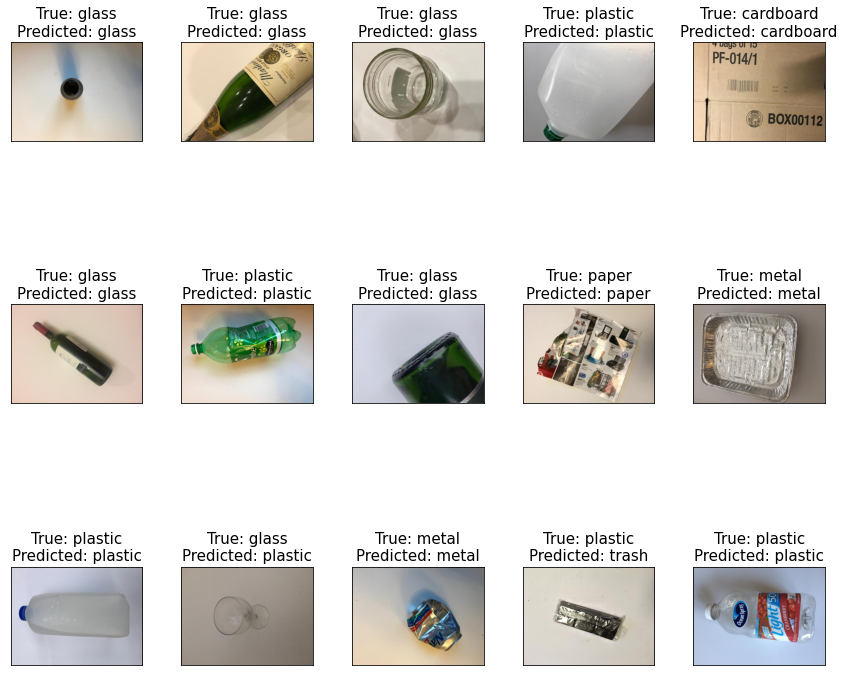

In [ ]:
# 여러 이미지를 예측(실제 값과 예측 값 labeling)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

In [ ]:
#앱에서 사용하기 위해 tensorflow lite로 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
with open('classifier.tflite', 'wb') as f:
  f.write(tflite_model)